In [1]:
# Importing Libraries And Modules
import os
import numpy as np
import tensorflow as tf                                                 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding

##### Processing The Labels of The Raw IMDB Data

In [2]:
imdb_dir = "/Users/huzaifa/Documents/Datasets/aclImdb"

In [3]:
train_dir = os.path.join(imdb_dir, 'train')

In [4]:
labels = []
texts = []

In [5]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

##### Tokenizing The Text of The Raw IMDB Data

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [7]:
max_len = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [8]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [9]:
words_index = tokenizer.word_index
print('Found %s unique tokens.' % len(words_index))

Found 88582 unique tokens.


In [10]:
data = pad_sequences(sequences, maxlen = max_len)

In [11]:
labels = np.asarray(labels)
print("Shape of data tensor: ", data.shape)
print("Shape of label tensor: ", labels.shape)

Shape of data tensor:  (25000, 100)
Shape of label tensor:  (25000,)


In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [13]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

##### Prepairing The GLoVE Word Embeddings File

In [14]:
glove_dir = '/Users/huzaifa/Documents/Datasets/glove'

In [15]:
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

In [16]:
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


##### Prepairing The GLoVE Word Embeddings Matrix

In [17]:
embedding_dim = 100

In [18]:
embedding_matrix = np.zeros((max_words, embedding_dim))

In [19]:
for word, i in words_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

##### Model Definition

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [21]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = max_len))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


##### Loading Pretrained Word Embeddings Into The Embedding Layer

In [22]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

##### Training And Evaluation

In [23]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [24]:
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32,
                    validation_data = (x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 117ms/step - loss: 2.5498 - acc: 0.4750 - val_loss: 0.6957 - val_acc: 0.5001
Epoch 2/10
7/7 [==============================] - 1s 188ms/step - loss: 0.6146 - acc: 0.6200 - val_loss: 0.7526 - val_acc: 0.5058
Epoch 3/10
7/7 [==============================] - 1s 223ms/step - loss: 0.5439 - acc: 0.7000 - val_loss: 0.7363 - val_acc: 0.5098
Epoch 4/10
7/7 [==============================] - 1s 245ms/step - loss: 0.4337 - acc: 0.7900 - val_loss: 0.7720 - val_acc: 0.5177
Epoch 5/10
7/7 [==============================] - 1s 234ms/step - loss: 0.6206 - acc: 0.7550 - val_loss: 0.7047 - val_acc: 0.5471
Epoch 6/10
7/7 [==============================] - 1s 179ms/step - loss: 0.1871 - acc: 0.9850 - val_loss: 1.2596 - val_acc: 0.4965
Epoch 7/10
7/7 [==============================] - 1s 105ms/step - loss: 0.2516 - acc: 0.8900 - val_loss: 1.1644 - val_acc: 0.4984
Epoch 8/10
7/7 [==============================] - 1s 113ms/step - loss: 0.0892 - acc: 0.99

In [25]:
model.save_weights('pretrained_glove_model.h5')

##### Plotting The Results

In [26]:
import matplotlib.pyplot as plt

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [28]:
epochs = range(1, len(acc) + 1)

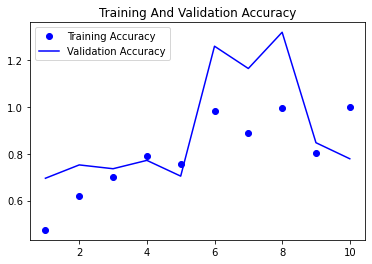

In [29]:
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'b', label = 'Validation Accuracy')
plt.title("Training And Validation Accuracy")
plt.legend()

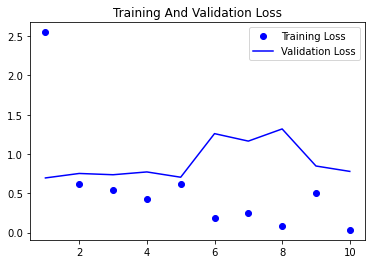

In [30]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training And Validation Loss')
plt.legend()
plt.show()

##### Training The Same Model Without Pretrained Word Embeddings

In [31]:
model1 = Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length = max_len))
model1.add(Flatten())
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [32]:
model1.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', 
               metrics = ['acc'])

In [33]:
history1 = model1.fit(x_train, y_train, epochs = 10, batch_size = 32, 
                      validation_data = (x_val, y_val)) 

Epoch 1/10
7/7 [==============================] - 1s 135ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6943 - val_acc: 0.4987
Epoch 2/10
7/7 [==============================] - 1s 110ms/step - loss: 0.4948 - acc: 0.9950 - val_loss: 0.7036 - val_acc: 0.5024
Epoch 3/10
7/7 [==============================] - 1s 154ms/step - loss: 0.2666 - acc: 0.9900 - val_loss: 0.7005 - val_acc: 0.5150
Epoch 4/10
7/7 [==============================] - 1s 134ms/step - loss: 0.1171 - acc: 1.0000 - val_loss: 0.7055 - val_acc: 0.5194
Epoch 5/10
7/7 [==============================] - 1s 105ms/step - loss: 0.0550 - acc: 1.0000 - val_loss: 0.7110 - val_acc: 0.5240
Epoch 6/10
7/7 [==============================] - 1s 107ms/step - loss: 0.0281 - acc: 1.0000 - val_loss: 0.7241 - val_acc: 0.5217
Epoch 7/10
7/7 [==============================] - 1s 108ms/step - loss: 0.0157 - acc: 1.0000 - val_loss: 0.7766 - val_acc: 0.5125
Epoch 8/10
7/7 [==============================] - 1s 102ms/step - loss: 0.0095 - acc: 1.00

##### PLotting The Results

In [34]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

In [35]:
epochs = range(1, len(acc) + 1)

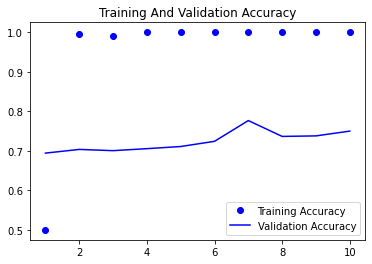

In [36]:
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'b', label = 'Validation Accuracy')
plt.title("Training And Validation Accuracy")
plt.legend()

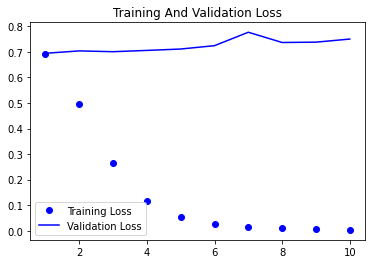

In [37]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training And Validation Loss')
plt.legend()
plt.show()